<a href="https://colab.research.google.com/github/Zahu05/Human-Action-Recognition/blob/main/Human_Action%20recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!pip install pafy youtube-dl moviepy
!pip install tensorflow opencv-contrib-python

In [ ]:
#libraries required
import os
#import youtube-dl
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from moviepy.editor import *
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model


In [ ]:
seed_constant=27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
%%capture
!wget --no-check-certificate https://w.crcv.ucf.edu/data/UCF50.rar
!unrar x UCF50.rar

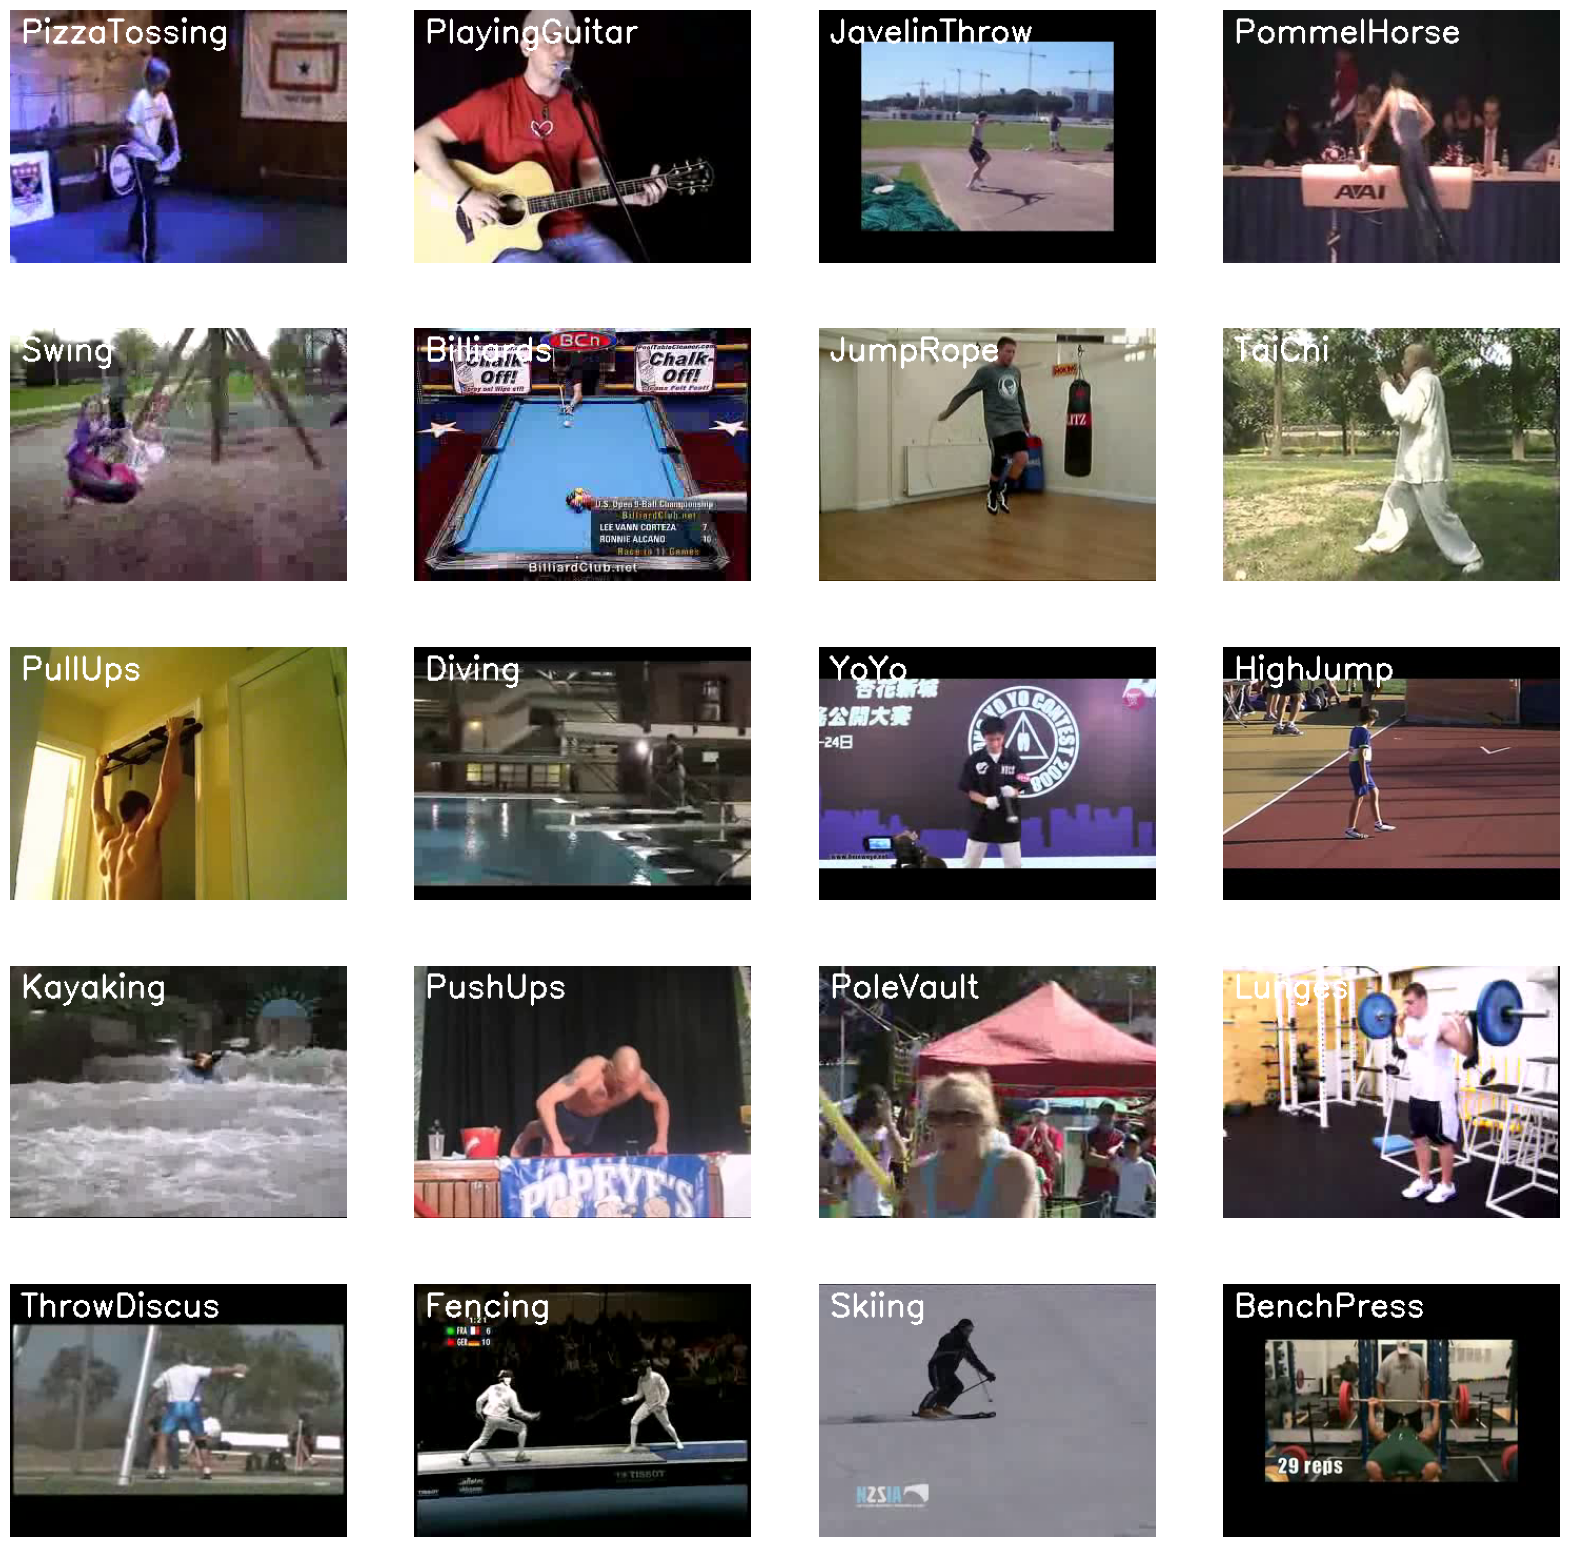

In [ ]:
#data visulaization

# specifying the size of figure
plt.figure(figsize=(20, 20))

# getting the names of all classes
path = '/content/drive/MyDrive/machine_learning/ml_project/UCF50'
all_classes_names = os.listdir(path)

# generating 20 random classes from 50 classes
random_range = random.sample(range(len(all_classes_names)), 20)

# we are going iterate through generated classes
for counter, random_index in enumerate(random_range, 1):
    # retrieving class names using random iterate
    selected_class_Name = all_classes_names[random_index]

    # video files are retrieved
    video_files_names_list = os.listdir(f'{path}/{selected_class_Name}')

    # selecting randomly selected video file
    selected_video = random.choice(video_files_names_list)

    # reading the first frame of video file
    video_reader = cv2.VideoCapture(f'{path}/{selected_class_Name}/{selected_video}')
    _, bgr_frame = video_reader.read()

    # releasing the video
    video_reader.release()

    # converting bgr to rgb format
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # writing the class name on video
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # displaying the frame
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

plt.show()



<h2> step-3: preprocessing of data</h2>


In [ ]:
#pre- processing
#specifying height and width to resize the video
IMAGE_HEIGHT,IMAGE_WIDTH= 64,64
#specifying the no of frames of video that will be feed to model as single sequence
SEQUENCE_LENGTH=20
#PATH SPECYFYING
DATASET_DIR="/content/drive/MyDrive/machine_learning/ml_project/UCF50"
#specifying the classes
CLASSES_LIST=['WalkingWithDog','TaiChi','Swing','HorseRace','HulaHoop']


<h2>Function to Resize,Extract,Normalize. the frames</h2>

In [ ]:
def frames_extraction(video_path):
  #declaring the list to store the video frames
  frames_list=[]
  #reading the video file using video capture object
  video_reader=cv2.VideoCapture(video_path)
  #getting total. no of frames in video
  video_frames_count=int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  #skipping few frames from video
  skip_frames_window=max(int(video_frames_count/SEQUENCE_LENGTH),1)
  #iterating through video frames
  for frame_counter in range(SEQUENCE_LENGTH):
    #setting the current frame position of the video
    video_reader.set(cv2.CAP_PROP_POS_FRAMES,frame_counter*skip_frames_window)
    #reading the frame from video
    success,frame=video_reader.read()
    if not success:
      break
    #resizing the frame to fix height and width
    resized_frames=cv2.resize(frame,(IMAGE_HEIGHT,IMAGE_WIDTH))
    #normalizing the resized frame by dividing it with 255 so that each pixel value (0-1)
    normalized_frame=resized_frames/255
    #appending the normalized frame to frame list
    frames_list.append(normalized_frame)

  #releasing the captured object(video)
  video_reader.release()
  return frames_list


<h2> function for dataset creation</h2>

In [ ]:
def create_dataset():
  #empty list to store feature, labels, video path
  features=[]
  labels=[]
  video_files_paths=[]
  #iterating to all classes mentioned in class list
  for class_index,class_name in enumerate(CLASSES_LIST):
    #displaying the name of exracted class
    print(f'extracting data of class:{class_name}')
    #getting the video files present in class dir
    files_list=os.listdir(os.path.join(DATASET_DIR,class_name))
    #iterating thru files
    for file_name in files_list:
      #getting complete video
      video_file_path=os.path.join(DATASET_DIR,class_name,file_name)
      #extracting frame of video
      frames=frames_extraction(video_file_path)
      # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
      if len(frames)==SEQUENCE_LENGTH:
        #appending the data to list
        features.append(frames)
        labels.append(class_index)
        video_files_paths.append(video_file_path)
  #converting list to arrays
  features=np.asarray(features)
  labels=np.array(labels)
  return features,labels,video_files_paths

<h2> utilising the above function to extract specific class</h2>




In [ ]:
features,labels,video_files_paths=create_dataset()

extracting data of class:WalkingWithDog
extracting data of class:TaiChi
extracting data of class:Swing
extracting data of class:HorseRace
extracting data of class:HulaHoop


In [ ]:
#converting the categorical data to numerical using one hot encoding
one_hot_encoded_labels=to_categorical(labels)


<h2>step 4: train_test_split</h2>


In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

<h2>setp5: LRCN=CNN+LSTM approch</h2>


In [ ]:
'''The Convolutional layers are used for spatial feature extraction from the frames,
 and the extracted spatial features are fed to LSTM layer(s) at each time-steps for temporal sequence modeling.
This way the network learns spatiotemporal features directly in an end-to-end training, resulting in a robust model.'''
'''We will also use TimeDistributed wrapper layer, which allows applying the same layer to every frame of the video independently.
So it makes a layer (around which it is wrapped) capable of taking input of shape (no_of_frames, width, height, num_of_channels)
if originally the layer's input shape was (width, height, num_of_channels) which is very beneficial as it allows to input the whole video into the model in a single shot.'''

#constructing the model
def create_lrcn_model():
  #sequential model to construct model
  model=Sequential()
  #defining model architecture
  #This line adds a 2D convolutional layer with 16 filters, each of size (3, 3), using the ReLU activation function.
  model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
  model.add(TimeDistributed(MaxPooling2D((4,4))))#reduces the spatial dimensions of the input by taking the maximum value over a (4, 4) window.
  model.add(TimeDistributed(Dropout(0.25)))#randomly sets a fraction of input units to 0 during training to prevent overfitting.

  model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D((4,4))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D((2,2))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D((2,2),padding='same')))
  model.add(TimeDistributed(Flatten()))#flat the array to 1-d

  #passing the flatten array to LSTM layer
  model.add(LSTM(32))# 32 bcoz balancing the complexity and capacity to learn i.e overfitting
  model.add(Dense(len(CLASSES_LIST),activation='softmax'))

  model.summary()
  return model

#calling the model
LRCN_model=create_lrcn_model()
print("model created successfully.....")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 20, 64, 64, 16)    448       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 20, 16, 16, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 20, 16, 16, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 20, 16, 16, 32)    4640      
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 20, 4, 4, 32)      0

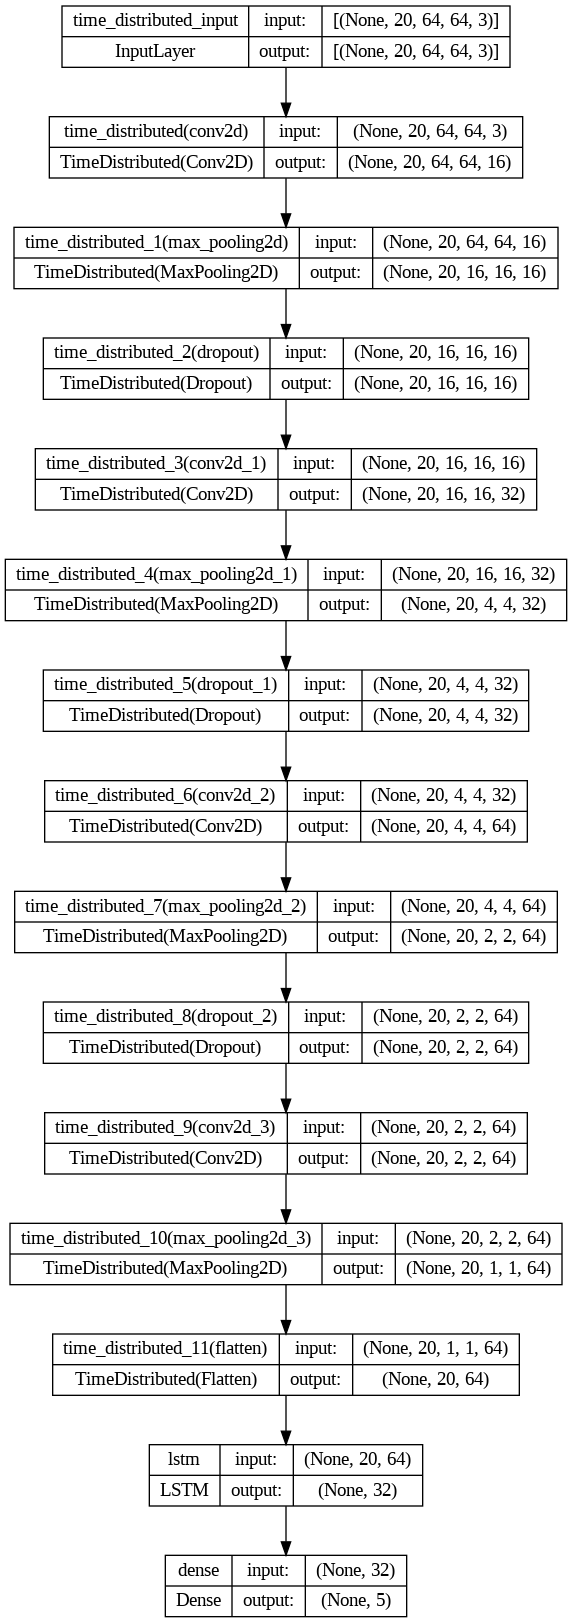

In [ ]:
#plotting the constructed structure LRCN
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

<h2>compile & training the model</h2>

In [ ]:
#creating an instance of early stopping callbacks
early_stopping_callback=EarlyStopping(monitor='val_loss',patience=15,mode='min',restore_best_weights=True)
#compiling the model
LRCN_model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=["accuracy"])
#It specifies the loss function to be categorical cross-entropy, which is commonly used for multi-class classification problems.
#training the model
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 ,shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])
#

Epoch 1/70
92/92 [==============================] - 10s 23ms/step - loss: 1.6036 - accuracy: 0.2262 - val_loss: 1.5588 - val_accuracy: 0.2500
Epoch 2/70
92/92 [==============================] - 1s 11ms/step - loss: 1.4204 - accuracy: 0.3787 - val_loss: 1.4376 - val_accuracy: 0.2500
Epoch 3/70
92/92 [==============================] - 1s 10ms/step - loss: 1.1918 - accuracy: 0.5259 - val_loss: 1.2625 - val_accuracy: 0.5217
Epoch 4/70
92/92 [==============================] - 1s 11ms/step - loss: 1.0057 - accuracy: 0.6158 - val_loss: 1.2532 - val_accuracy: 0.4891
Epoch 5/70
92/92 [==============================] - 1s 10ms/step - loss: 0.8029 - accuracy: 0.7193 - val_loss: 1.1731 - val_accuracy: 0.5761
Epoch 6/70
92/92 [==============================] - 1s 10ms/step - loss: 0.8032 - accuracy: 0.7275 - val_loss: 1.0045 - val_accuracy: 0.6196
Epoch 7/70
92/92 [==============================] - 1s 10ms/step - loss: 0.7350 - accuracy: 0.7330 - val_loss: 1.1109 - val_accuracy: 0.6304
Epoch 8/70
9

#evaluating the model

In [ ]:
#evaluation
model_evaluation_history=LRCN_model.evaluate(features_test,labels_test)
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
# Specify the folder path in your Google Drive where you want to save the model.
folder_path = '/content/drive/MyDrive/machine_learning/ml_project/'

# Define the complete file path including the folder path where the model will be saved.
model_file_path = folder_path + model_file_name

# Save the Model.
LRCN_model.save(model_file_path)


5/5 [==============================] - 1s 92ms/step - loss: 0.5920 - accuracy: 0.8235


  saving_api.save_model(



# visualization of trainign & loss metrics

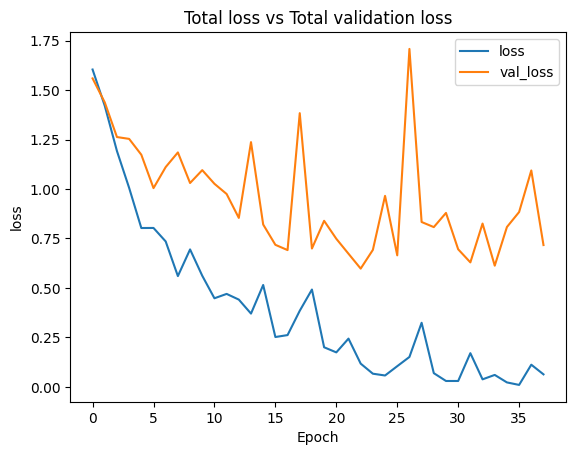

In [ ]:
#loss metric
def plot_metric(history, metric, val_metric, title):
    plt.plot(history.history[metric], label=metric)
    plt.plot(history.history[val_metric], label=val_metric)
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()
    plt.show()
plot_metric(LRCN_model_training_history,'loss','val_loss','Total loss vs Total validation loss')


# visualizing the accuracy

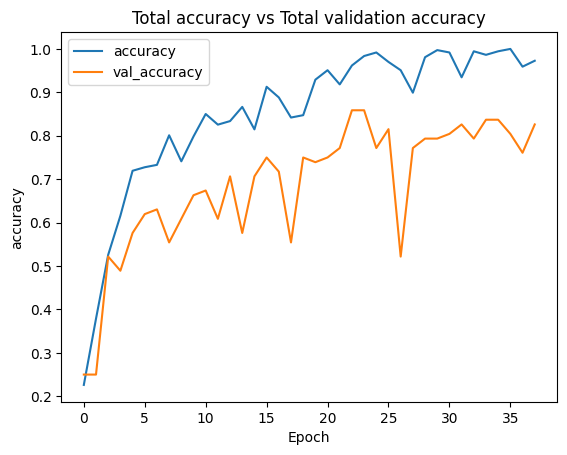

In [ ]:
plot_metric(LRCN_model_training_history,'accuracy','val_accuracy','Total accuracy vs Total validation accuracy')


# testing of you tube videos


In [ ]:
!youtube-dl --update
!pip install pytube


It looks like you installed youtube-dl with a package manager, pip, setup.py or a tarball. Please use that to update.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.7 MB/s eta 0:00:00


In [ ]:
from pytube import YouTube

def download_youtube_video(youtube_video_url, output_dir):
    yt = YouTube(youtube_video_url)
    video_title = yt.title
    #constructing output file path
    output_file_path= f'{output_dir}/{video_title}.mp4'
    stream = yt.streams.filter(progressive=True, file_extension='mp4').first()
    if stream:
        stream.download(output_dir)
        return video_title
    else:
        return None

# Create the output directory if it doesn't exist
test_videos_dir = '/content/drive/MyDrive/machine_learning/ml_project'
os.makedirs(test_videos_dir, exist_ok=True)

# Download the YouTube video
video_title = download_youtube_video('https://www.youtube.com/watch?v=8u0qjmHIOcE', test_videos_dir)
#testing you tube videos
#video_title = download_youtube_video('https://www.youtube.com/watch?v=6U8ipxSRAUA', test_videos_dir)

# Get the YouTube Video's path we just downloaded.
input_video_file_path = f'{test_videos_dir}/{video_title}.mp4'



#action recognition function

In [ ]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform action recognition on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    output_file_path: The path where the ouput video with the predicted action being performed overlayed will be stored.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():

        # Read the frame.
        ok, frame = video_reader.read()

        # Check if frame is not read properly then break the loop.
        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)

        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:

            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]

        # Write predicted class name on top of the frame.
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Write The frame into the disk using the VideoWriter Object.
        video_writer.write(frame)

    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

#performing action recognition on test video

In [ ]:
# Construct the output video path.
output_video_file_path = f'{test_videos_dir}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path,SEQUENCE_LENGTH)

# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

1/1 [==============================] - 0s 18ms/step
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t:  99%|█████████▊| 856/867 [00:02<00:00, 383.04it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/machine_learning/ml_project/Test Video-Output-SeqLen20.mp4, 360000 bytes wanted but 0 bytes read,at frame 866/867, at time 31.04/31.04 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

                                                               

Moviepy - Done !
Moviepy - video ready __temp__.mp4
